# Collaborative Filtering
With your best friends; Cookie Optimizers :D 

# MovieLens
## Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Data Loaders

In [5]:
def condence(nparr):
    uniq = np.unique(nparr)
    name2idx = {o:i for i,o in enumerate(uniq)}
    return np.array([name2idx[o] for o in nparr])

class MovieLensDataset(Dataset):
    def __init__(self, filename):
        self.rawdata = pd.read_csv(filename)
        self.rawdata["userId"] = condence(self.rawdata["userId"].values)
        self.rawdata["movieId"] = condence(self.rawdata["movieId"].values)

    def __len__(self):
        return len(self.rawdata)

    def __getitem__(self, idx):
        idx = idx.item()
        users = self.rawdata.iloc[idx, 0]
        items = self.rawdata.iloc[idx, 1]
        ratings = self.rawdata.iloc[idx, 2]
        
        return (users, items, ratings)
    
    def items (self):
        n_users = self.rawdata["userId"].nunique()
        n_items = self.rawdata["movieId"].nunique()
        
        return [n_users, n_items]

def getLoaders(dataset, batchsize, shuffle, sizes):
    train_size = int(sizes[0] * len(dataset))
    val_size = int(sizes[1] * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
    
    return [DataLoader(data, batch_size = batchsize, shuffle = shuffle) for data in [train_data, val_data, test_data]]

## Model

In [6]:
# Model
class CFNN(nn.Module):
    def __init__(self, num_users, num_items, emb_size, n_hidden_1, n_hidden_2, p_dropout):
        super(CFNN, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.lin1 = nn.Linear(emb_size*2, n_hidden_1)
        self.lin2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.linOut = nn.Linear(n_hidden_2, 1)
        self.drop0 = nn.Dropout(p_dropout)
        self.drop1 = nn.Dropout(p_dropout)
        self.drop2 = nn.Dropout(p_dropout)
        
    def forward(self, u, v):
        U = self.user_emb(u)
        V = self.item_emb(v)
        x = F.relu(torch.cat([U, V], dim=1))
        x = self.drop0(x)
        x = F.relu(self.lin1(x))
        x = self.drop1(x)
        x = F.relu(self.lin2(x))
        x = self.drop2(x)
        x = self.linOut(x)
        return x

## Traning Loop

In [7]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for (users, items, ratings) in train_loader:
        users = users.long().to(device)
        items = items.long().to(device)
        ratings = ratings.float().to(device)
        ratings = ratings.unsqueeze(1)
        
        optimizer.zero_grad()
        output = model(users, items)
        loss = criterion(output, ratings)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    return train_loss / len(train_loader)
    

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (users, items, ratings) in val_loader:
            users = users.long().to(device)
            items = items.long().to(device)
            ratings = ratings.float().to(device)
            ratings = ratings.unsqueeze(1)
            
            output = model(users, items)
            loss = criterion(output, ratings)

            val_loss += loss.item()

    return val_loss / len(val_loader)

def train_model(train_loader, val_loader, max_epochs, batchsize, model, criterion, optimizer, modelpath=None):
    # check path for early stopping
    if modelpath != None:
        patience_count = 0
        torch.save(model, modelpath)
    
    # Train model
    best_loss = (-1, -1, 1e15)
    train_losses = []
    val_losses = []
    
    for epoch in range(1, max_epochs + 1):
        # train and validate
        train_loss = train(model, train_loader, optimizer, criterion)
        val_loss = validate(model, val_loader, criterion)
        
        val_losses += [val_loss]
        train_losses += [train_loss]
        print(f'Epoch {epoch:3d} | Train average loss: {train_loss:3.5f} | Validation average loss: {val_loss:3.5f}')
        
        # Early stopping
        if val_loss < best_loss[2]:
            best_loss = (epoch, train_loss, val_loss)
            
            if modelpath != None:
                patience_count = 0
                torch.save(model, modelpath)
        if modelpath != None:
            if patience_count == 10:
                model = torch.load(modelpath)
                break
            else:
                patience_count += 1

    # Plot loss
    plt.plot(range(1,epoch+1), val_losses, color='b')
    plt.plot(range(1,epoch+1), train_losses, color='g')
    plt.axvline(x=best_loss[0], color='r')
    plt.show()
    print(f"Best validation loss at epoch {best_loss[0]} | Train loss: {best_loss[1]:.5} | Validation loss {best_loss[2]:.5}")
    
    # return loaded model if early stop otherwise, finished model.
    return model

## Parameters

In [8]:
# Data params
datasetpath = '../datasets/movielens-large/ratings.csv'
#datasetpath = '../datasets/movielens-small/ratings.csv'
shuffle_data = True
size_splits = [0.7, 0.2, 0.1]
dataset = MovieLensDataset(datasetpath)

In [9]:
# Model params
n_users, n_items = dataset.items()
emb_size=500
n_hidden_1=1000
n_hidden_2=1000
p_dropout = 0.3
model = CFNN(n_users, n_items, emb_size, n_hidden_1, n_hidden_2, p_dropout).to(device)

In [10]:
# Training params
modelpath = '../torch_models/movielens/best.pth'
max_epochs = 100
batch_size = 50
learning_rate = 0.001
weight_decay = 1e-6
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [11]:
# Data loaders
train_loader, val_loader, test_loader = getLoaders(dataset, batch_size, shuffle_data, size_splits)

# Print info on model and loaders
ls = [len(l) for l in [train_loader, val_loader, test_loader]]
mbls = max([len(str(l)) for l in ls])
mls = max([len(str(l*batch_size)) for l in ls])

print(model, "\n")
print(f"Amount of batches in training set:   {ls[0]:{mbls}d} | Total samples: {ls[0]*batch_size:{mls}d}")
print(f"Amount of batches in validation set: {ls[1]:{mbls}d} | Total samples: {ls[1]*batch_size:{mls}d}")
print(f"Amount of batches in testing set:    {ls[2]:{mbls}d} | Total samples: {ls[2]*batch_size:{mls}d}")

CFNN(
  (user_emb): Embedding(10386, 500)
  (item_emb): Embedding(22085, 500)
  (lin1): Linear(in_features=1000, out_features=1000, bias=True)
  (lin2): Linear(in_features=1000, out_features=1000, bias=True)
  (linOut): Linear(in_features=1000, out_features=1, bias=True)
  (drop0): Dropout(p=0.3)
  (drop1): Dropout(p=0.3)
  (drop2): Dropout(p=0.3)
) 

Amount of batches in training set:   14474 | Total samples: 723700
Amount of batches in validation set:  4136 | Total samples: 206800
Amount of batches in testing set:     2068 | Total samples: 103400


## Train Model

Epoch   1 | Train average loss: 0.99805 | Validation average loss: 0.88322
Epoch   2 | Train average loss: 0.84583 | Validation average loss: 0.81756
Epoch   3 | Train average loss: 0.80705 | Validation average loss: 0.78396
Epoch   4 | Train average loss: 0.78281 | Validation average loss: 0.78443
Epoch   5 | Train average loss: 0.76766 | Validation average loss: 0.79383
Epoch   6 | Train average loss: 0.75648 | Validation average loss: 0.78008
Epoch   7 | Train average loss: 0.74767 | Validation average loss: 0.75767
Epoch   8 | Train average loss: 0.73970 | Validation average loss: 0.75772
Epoch   9 | Train average loss: 0.73297 | Validation average loss: 0.76342
Epoch  10 | Train average loss: 0.72662 | Validation average loss: 0.76631
Epoch  11 | Train average loss: 0.72093 | Validation average loss: 0.75364
Epoch  12 | Train average loss: 0.71682 | Validation average loss: 0.74270
Epoch  13 | Train average loss: 0.71301 | Validation average loss: 0.76035
Epoch  14 | Train average

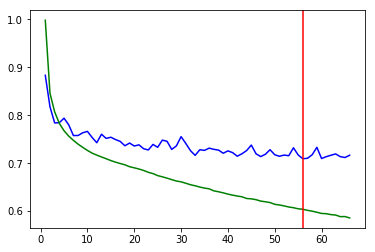

Best validation loss at epoch 56 | Train loss: 0.60393 | Validation loss 0.70924


In [12]:
model_trained = train_model(train_loader,
                            val_loader, 
                            max_epochs, 
                            batch_size, 
                            model, 
                            criterion, 
                            optimizer, 
                            modelpath)

## Test Model

In [14]:
model_trained.eval()
test_loss = 0
with torch.no_grad():
    for (users, items, ratings) in test_loader:
        users = users.long().to(device)
        items = items.long().to(device)
        ratings = ratings.float().to(device)
        ratings = ratings.unsqueeze(1)
        output = model_trained(users, items)

        test_loss += criterion(output, ratings).item() # sum up batch loss

test_loss /= len(test_loader)
# UNCOMMENT ONLY WHEN MODEL IS COMPLETELY FINISHED
print(f'Final test average loss: {test_loss}')

Final test average loss: 0.7076702056384179
